# Training

This notebook includes an example training loop for the models.

In [ ]:
import torch
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import WeightedRandomSampler

from torch.utils.tensorboard import SummaryWriter

from model.one_model.one_stage_models import ResNet50OneStage
from data.dataset import CheXpertDataset

%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots


os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent the kernel from dying. 

## Datasets

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224, standard in this field 
    transforms.Grayscale(num_output_channels=1),  # Make sure the output is single-channel
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])
# conv1 had kernel (7,7), causing problems with our input_channels = 1

targets = {
            # "sex": 1,
            # "age": 2,
            # "frontal/lateral": 3,
            # "ap/pa": 4,
            #"no_finding": 5,
            #"enlarged_cardiomediastinum": 6,
            #"cardiomegaly": 7,
            #"lung_opacity": 8,
            #"lung_lesion": 9,
            #"edema": 10,
            #"consolidation": 11,
            #"pneumonia": 12,
            #"atelectasis": 13,
            #"pneumothorax": 14,
            #"pleural_effusion": 15,
            #"pleural_other": 16,
            #"fracture": 17,
            "support_devices": 18, 
        }

train_dataset = CheXpertDataset(
    csv_file="./data/train.csv",
    root_dir="../image_data/",
    targets=targets,
    transform=transform,
)

val_dataset = CheXpertDataset(
    csv_file="./data/valid.csv",
    root_dir="../image_data/",
    targets=targets,
    transform=transform,
)

Train dataset size: 191009
Valid dataset size: 234
Example
[1.]
torch.Size([1, 224, 224])


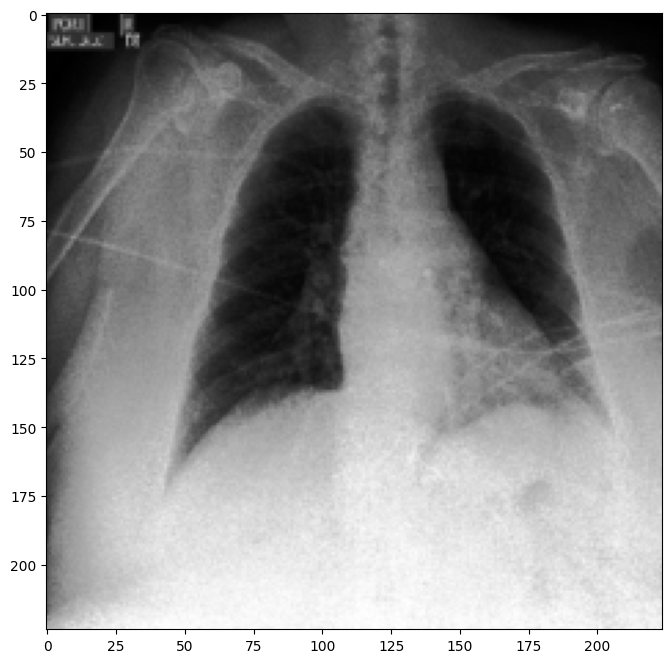

In [3]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Valid dataset size: {len(val_dataset)}")

print("Example")
img, labels = train_dataset[0]
print(f"{labels}")
print(f"{img.shape}")
img = img.squeeze().numpy()
plt.imshow(img, cmap='gray')

## Define model

In [4]:
params = {
    "lr": 0.001,
    "batch_size": 16,
    "num_epochs": 1,
    "sampling": True
}

loss_fn = torch.nn.BCEWithLogitsLoss()


model = ResNet50OneStage(params=params, num_classes=1, input_channels=1)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Training

In [5]:
"""
Train the model.
"""

path = os.path.join("logs", "cls_logs")
num_of_runs = len(os.listdir(path)) if os.path.exists(path) else 0
path = os.path.join(path, f"run_{num_of_runs + 1}")

# Create tensorboard logger
tb_logger = SummaryWriter(path)

# Train with sampler
model.train(train_dataset, val_dataset, loss_fn, tb_logger, epochs=params["num_epochs"], weighted_sampling=params["sampling"]) 

Training Epoch 1/1:   0%|                                                                                                                                                     | 0/11939 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 1, 3, 3], expected input[1, 12, 224, 224] to have 1 channels, but got 12 channels instead